In [204]:
import pandas as pd
import json 
import urllib
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image
import math

In [205]:
import pandas as pd
from sklearn.metrics.pairwise import sigmoid_kernel
import tensorflow as tf
# import cv2
# from server.logger import Logger
import numpy as np
import os
# import server.image_operations as image_operations
from PIL import Image
import server.IoU as IoU

In [206]:
# import os
# import random
import cv2
# from tqdm import tqdm
# import pandas as pd
import numpy as np         
import math
import matplotlib.pyplot as plt
# import xml.etree.ElementTree as ET
# from PIL import Image
# from pathlib import Path
# from dataset import Dataset
import tensorflow as tf
# from logger import Logger

class ImageOperations():

    def __init__(self, win_size, target_img_size):
        self.win_size =  win_size
        self.target_img_size = target_img_size
        
        # self.log = logger
        # Для того чтобы загнать катринку в нейронную сеть, необходимо разбить изображение на квадраты размером win_size.
        # следующие два параметра оптределяют к-во этих квадратов. 
        self.steps_x = math.ceil(self.target_img_size[0]/100)#self.win_size)
        self.steps_y = math.ceil(self.target_img_size[1]/100)#self.win_size)

        # запомнить позицию каждого квадрата.
        self.step_x = 100#math.floor(self.target_img_size[0]/math.ceil(self.target_img_size[0]/self.win_size)) 
        self.step_y = 100#math.floor(self.target_img_size[1]/math.ceil(self.target_img_size[1]/self.win_size))
        self.windows_coords = self.calc_window_coords()
        self.min_object_size = 15
        print('Hello!!!')


# Необходимо принять изображение. Определить его исходный размер. 
# уменьшить его размер до 600х800.
# Разрезать на составные части
# Получить ответ.
# Объединить прямоугольники, определить их реальные координаты. 
# Пересичитатьих позицию на исходном изображении.
# Вывести ответ в виде словаря.

    def create_mask(self, bb, x, class_index):
        """Создаем маску для bounding box'a такого же шейпа как и изображение"""
        rows,cols, _ = x.shape
        y_ind = np.zeros((rows, cols)) 
        bb = bb.astype(np.int)

        if class_index > 0:
            y_ind[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0]] = class_index 
        return y_ind

    def create_bb_array(self, x,class_index):
        """Генерируем массив bounding box'a из столбца train_df"""
        if class_index == 0:
            res = np.array([-1,-1,-1,-1]) 
        else:
            res = np.array([x[0],x[1],x[2],x[3]])      
        return res

    def mask_to_bb(self, mask):
        """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
        # bbx = []
        # for i in range(len(class_names)-1):
        cols, rows = np.nonzero(mask)
        if len(cols) == 0:
            bb=[-1,-1,-1,-1]
        else:
            top_row = np.min(rows)
            left_col = np.min(cols)
            bottom_row = np.max(rows)
            right_col = np.max(cols)
            bb = [top_row, left_col, bottom_row-top_row, right_col-left_col]
        return np.array(bb, dtype=np.float32)

    def calc_window_coords(self):
        '''Вычисляет координаты квадратных областей, (кусков) на которые будет 
        разреанно исходное иображение.'''

        window_coords= []
        for i in range(self.steps_y):
            for j in range(self.steps_x):
                pos_x = self.step_x*j
                pos_y = self.step_y*i
                if pos_x+self.win_size > self.target_img_size[0]:
                    pos_x = self.target_img_size[0]-self.win_size
                if pos_y+self.win_size > self.target_img_size[1]:
                    pos_y = self.target_img_size[1]-self.win_size   
                window_coords.append([pos_y, pos_x, self.win_size, self.win_size])
        return window_coords
    
    def split_image(self, img, bbx=None, class_index=1):
        '''Процедура для разбиения изображения на квадраты'''

        is_not_bbx =False
        if not bbx:
            is_not_bbx=True
            bbx = np.array([-1,-1,-1,-1], dtype='float')
        mask = self.create_mask(bbx, img, class_index)
    # разделим изображение на составные части и возращем кусочки small_imgs and small_bbx
        img_combined = np.concatenate([img, mask[..., None]], axis=2)
        X_batch=[]
        y_batch=[]
        for coord in self.windows_coords:
            combined = img_combined[coord[0]:(coord[0]+coord[2]), coord[1]:(coord[1]+coord[3])]
            X_batch.append(combined[...,:3])
            bb = self.mask_to_bb(combined[...,3])
            y_batch.append(bb)

        X_batch = np.array(X_batch, dtype='float') /255.0
        y_batch = np.array(y_batch, dtype='float') /255.0

        if is_not_bbx:
            return X_batch
        else:    
            return X_batch, y_batch

    def image_prepare(self, image, target_img_size, split_image=False):
        '''Подготавливает изображение к отправке его в нейронную сеть.'''
        try:
            #----------------------------------------------------------------
            plt.imshow(image)
            plt.show()
            #----------------------------------------------------------------
            print('>>>',image.size)
            image = image.resize(target_img_size)
            image  = tf.keras.preprocessing.image.img_to_array(image.convert('RGB'))
            # image = image/255.0
            
            # plt.imshow(image)
            # plt.show()
            #----------------------------------------------------------------
            # image = cv2.cvtColor((image).astype(np.uint8), cv2.COLOR_BGR2RGB)
            # image = image.resize(target_img_size)#, Image.ANTIALIAS)
            # image = cv2.resize(image, target_img_size)
            # image = image/255.0
            
            # plt.imread(image)
            # plt.show()clear
            image_list=[]
            if split_image:
                print("split image")
                image_list = self.split_image(image) # Разбиваем изображение на тайлы.
                
            print('img_list_len', len(image_list))
            show_result(image_list)    
        except Exception as e:
            # self.log.write(f'Exception: Возникла ошибка на этапе предобработки изображения. {str(e)}')
            print(f'Exception: Возникла ошибка на этапе предобработки изображения. {str(e)}')
    
        return image_list if split_image else image    

    def combined_bb(self, scores, bbx, class_name, threshold=0.9):
        '''Перед отправкой в нейронную сеть изображение было разбито на более мелкие. 
           Данный метод объединяет box-ы обнаруженные на разных частях изображения в один.'''

        bounding_box = [-1, -1, -1, -1] 
        if np.max(scores) < threshold:
            print('max_score: ', np.max(scores))
            return bounding_box
        top_row,left_col,bottom_row,right_col= -1,-1,-1,-1

        counter = 0
        for i, b in enumerate(bbx):
            if (scores[i] >= threshold):
               
                box = b * self.win_size
                box[0] += self.windows_coords[i][1]-box[2]/2
                box[1] += self.windows_coords[i][0]-box[3]/2
                box[2] += box[0]  
                box[3] += box[1]
                print('score: ', scores[i],'box: ',box)
             # Огромный костыль. т.к. модель не очень хорошо умеет локацию подписей. Поэтому, нужно немного ей помочь.
                if(class_name=='sign') and (box[1]< self.target_img_size[1]/2): # это условие работает, только для подписей. для логотипов оно не корректно.
                    continue
                if(class_name=='logo') and (box[1]> self.target_img_size[1]/2): # это условие работает, только для подписей. для логотипов оно не корректно.
                    continue
                if (np.abs(box[2] -box[0])< self.min_object_size) or (np.abs(box[3]-box[1])<self.min_object_size):
                    continue

                counter +=1
                if counter==1:
                    top_row = box[0] 
                    left_col = box[1]
                    bottom_row = box[2]
                    right_col = box[3]
                else:
                    if(np.abs(top_row - box[0])> self.win_size/2) or (np.abs(left_col - box[1])> self.win_size/2):
                        print(np.abs(top_row - box[0]), np.abs(left_col - box[1]) )
                        continue
                    top_row = box[0] if box[0] < top_row else top_row
                    left_col = box[1] if box[1] < left_col else left_col
                    bottom_row = box[2] if box[2] > bottom_row else bottom_row
                    right_col = box[3] if box[3] > right_col else right_col
        
        bounding_box = [top_row, left_col, bottom_row-top_row, right_col-left_col]
        print("combined_bb return: ",bounding_box)
        return bounding_box
    
    def get_original_size_bb(self, bb, old_size): # исходный размер изображения тоже нужно как-то анализировать.
        '''Приводит координаты box-ов к масштабу исходного изображения.'''
        scale_width = old_size[0]/self.target_img_size[0]
        scale_height = old_size[1]/self.target_img_size[1]
        print(self.target_img_size[0], self.target_img_size[1])
        print(scale_width, scale_height)
        original_bb = [0,0,0,0]
        original_bb[0] = int(np.round(bb[0]*scale_width))
        original_bb[1] = int(np.round(bb[1]*scale_height))
        original_bb[2] = int(np.round(bb[2]*scale_width))
        original_bb[3] = int(np.round(bb[3]*scale_height))
        print('oroginal BB: ', original_bb)
        return original_bb

In [207]:
IM_SIZE = (600,800) # Все изображения будут приведены этому размеру
win_size = 224  # Будем подавать изображение в нейронную сеть по частям. - это размер квадратного окна прохода.
min_object_size = 20

In [208]:
steps_x = math.ceil(IM_SIZE[0]/100)#win_size)
steps_y = math.ceil(IM_SIZE[1]/100)#win_size)

# запомнить позицию каждого квадрата.
step_x = 100# math.floor(IM_SIZE[0]/math.ceil(IM_SIZE[0]/win_size)) 
step_y = 100#math.floor(IM_SIZE[1]/math.ceil(IM_SIZE[1]/win_size)) 

step_y, step_x
win_coords = [ ]
for i in range(steps_y):
    for j in range(steps_x):
        pos_x = step_x*j
        pos_y = step_y*i
        if pos_x+win_size> IM_SIZE[0]:
            pos_x = IM_SIZE[0]-win_size
        if pos_y+win_size> IM_SIZE[1]:
            pos_y = IM_SIZE[1]-win_size   
        win_coords.append([pos_y, pos_x, win_size, win_size])
print(len(win_coords))

48


In [209]:
def show_result(sample_imgs, scores=None, sample_bbx=None):
    fig = plt.figure(figsize=(15, 20))
    # print(sample_imgs.shape)
    for j in range(len(sample_imgs)):
        ax = fig.add_subplot(steps_y, steps_x, j+1)
        ax.imshow(sample_imgs[j])
        
        if sample_bbx:
            bb = sample_bbx[j]
            # print(bb)
            wr = bb[2]*win_size
            hc = bb[3]*win_size
            tr = bb[0]*win_size - wr/2
            tc = bb[1]*win_size - hc/2
            rect = plt.Rectangle((tr, tc), wr, hc,fill=False, color='red')
            ax.add_patch(rect)
        if scores:
            ax.title.set_text(f'{scores[j]:.2f}') 
        # print(sigmoid(bb[0]))
        plt.xticks([]), plt.yticks([])
    plt.show()

In [210]:
class ObjectLocalization():

    def __init__(self, model_path_logo, model_path_sign, class_names, win_size, target_image_size, threshold): # Написать стоит и други процедуры после инициализации.
        os.environ['CUDA_VISIBLE_DEVICES'] = '' 

        self.target_image_size = target_image_size
        self.threshold = threshold  
        print('Load models')
        # Загрузим модель.
        self.model_logo = tf.keras.models.load_model(model_path_logo, custom_objects={"IoU":IoU})
        self.model_sign = tf.keras.models.load_model(model_path_sign, custom_objects={"IoU":IoU})

        self.image_operations = ImageOperations(win_size, target_image_size)
        self.orign_width = 0
        self.orign_height = 0

        self.class_names= class_names
        print('ObjectLocalization initialize')
        # self.logger.write('ObjectLocalization initialize')

    def get_boxes_location(self, pred):
        '''Определим местоположение ограничивающего прямоугольника на изображении.'''
        class_name = ''
        max_value = pred.max()
        print(max_value)
        if max_value < self.threshold:
            class_name='void' # изображение не содержит ни логотипов ни подписей.
        else:
            # Загрузим изображение.
            pred_y = tf.argmax(pred, axis=1, output_type=tf.int32)
            class_name = self.class_names[pred_y[0]]
        return class_name
    

    def predict_interpretation(self, predict, class_name):
        '''Выполняет интерпредацию предсказанного значения.'''
        position={}
        print(predict[0][:,0].max())
        if predict[0][:,0].max() > self.threshold:

            bbx = self.image_operations.combined_bb(predict[0], predict[1], class_name, self.threshold)   # Объединяем боксы с разных тайлов в один.
            bbx = self.image_operations.get_original_size_bb(bbx,(self.orign_width, self.orign_height))
            # Здесь, по идее, можно было бы создать отдельный класс и передать в него свойства. А, затем как-то его сериализовать.
            position['type']= class_name  
            position['position'] = {'left':bbx[0],'top':bbx[1],'width':bbx[2],'height':bbx[3]} # координаты объекта
            position['source'] = {'width':self.orign_width, 'height': self.orign_height}
        return position 


    def get_objects_localization(self, image):
        '''Отправляет изображение в нейронную сеть. возвращает результат предсказания.'''
        object_list = []
        try:
            # image = np.array(image)
            # перед изменением размера необходимо запомнить изначальный размеры изображения.
            self.orign_width, self.orign_height = image.size 
            print(self.orign_width, self.orign_height, self.target_image_size )
            image_list = self.image_operations.image_prepare(image, self.target_image_size, split_image=True)
            print(image_list.shape)

            pred = self.model_logo.predict(image_list)
            print(pred)
            # redict = model_logo_1.predict(img_list)
            # show_result(image_list,pred[0][:,0],pred[1]) 
            
            position = self.predict_interpretation(pred, self.class_names[0])
            if position != {}:
                object_list.append(position)
                # self.logger.write(f'{position}')

            # image_list = self.image_operations.image_prepare(image, self.target_image_size, split_image=True)
            # pred = self.model_sign.predict(image_list)     
            # position = self.predict_interpretation(pred, self.class_names[1])
            # if position != {}:
            #     object_list.append(position)    

        except Exception as e:
            # self.logger.write(f'Exception: Ошибка интерпретации модели! Не удалось выполнить предскание. {str(e)}')
            print(f'Exception: Ошибка интерпретации модели! Не удалось выполнить предскание. {str(e)}')

        if object_list=={}:    # если словарь все еще пуст - возвращаем 'void'  
                object_list.append({'type': 'void'})
                print('Изображение не содержит ни логотипов ни подписей')
        return object_list

Walcom to ObjectLocalization!
(2560, 3296)
Load models
Hello!!!
ObjectLocalization initialize
2560 3296 (600, 800)


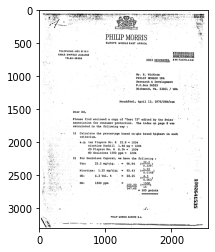

>>> (2560, 3296)
split image
img_list_len 48


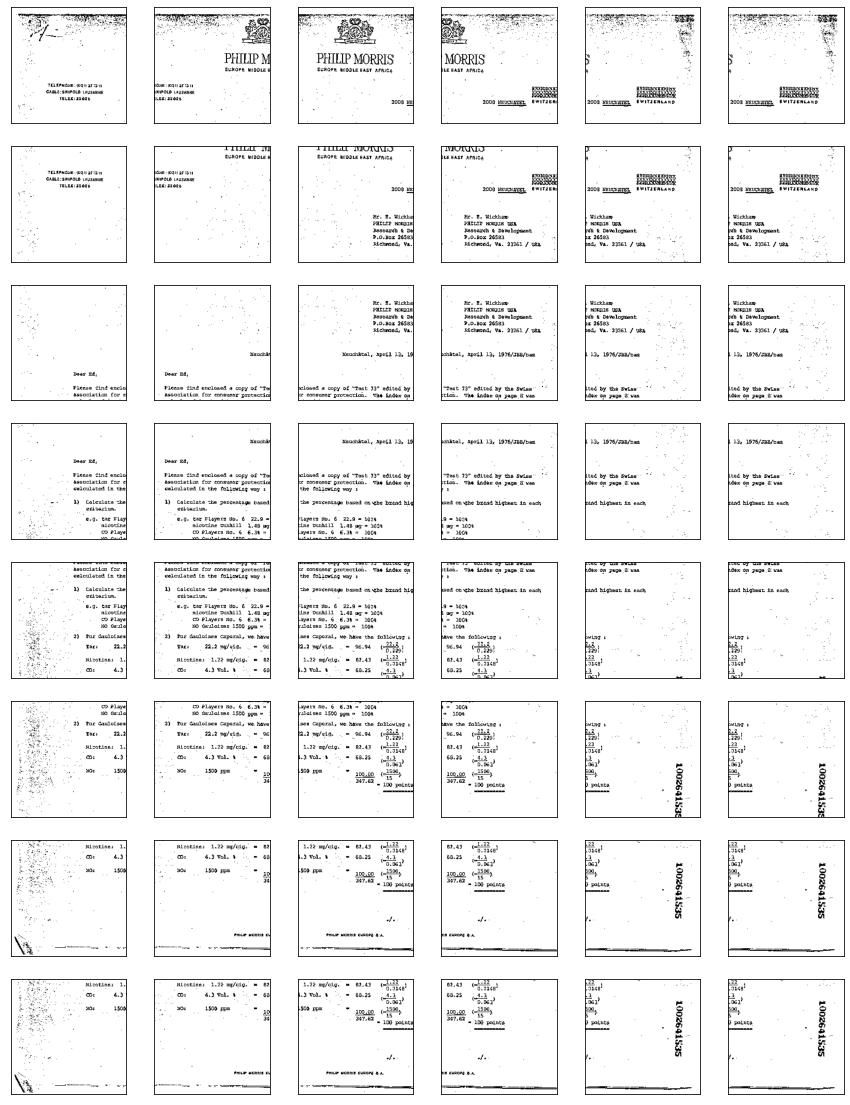

(48, 224, 224, 3)
[array([[4.2051938e-01],
       [9.9815536e-01],
       [9.9999768e-01],
       [9.9998856e-01],
       [7.9125702e-02],
       [7.9125702e-02],
       [1.3923645e-03],
       [1.7583370e-04],
       [4.1822223e-05],
       [2.8358281e-02],
       [5.5274695e-02],
       [5.5274695e-02],
       [3.0143261e-03],
       [2.6433468e-03],
       [1.1559427e-03],
       [2.0518899e-04],
       [2.6026368e-04],
       [2.6026368e-04],
       [1.2493432e-03],
       [1.9147992e-04],
       [3.0117155e-05],
       [8.5171359e-06],
       [5.7347013e-05],
       [5.7347013e-05],
       [1.4683604e-04],
       [7.6009184e-07],
       [2.1264641e-07],
       [6.3463614e-07],
       [2.5802851e-04],
       [2.5802851e-04],
       [5.0401688e-04],
       [1.7776902e-05],
       [2.0894286e-06],
       [9.5507648e-06],
       [7.5491369e-03],
       [7.5491369e-03],
       [2.3163855e-03],
       [9.1093847e-05],
       [5.8825488e-05],
       [1.0796400e-04],
       [6.9141388e-04

In [211]:
print(("Walcom to ObjectLocalization!"))
file_dir = os.path.dirname(os.path.realpath('__file__'))
# classes_path = os.path.join(file_dir,'models/class_names.txt')
model_path_logo = os.path.join(file_dir,'models/model_logo_resnet_100.h5')
model_path_sign = os.path.join(file_dir,"models/model_sign_resnet.h5",)
image_path = 'images/bfr18e00-page02_1.tif'
loger_patch = os.path.join(file_dir,'server/log')
img = Image.open(os.path.join(file_dir,image_path))
# plt.imshow()
class_names = ['logo','sign']
win_size=224
threshold=0.8
target_image_size= (600, 800)

print(img.size)

# img = img.resize(target_image_size).convert('RGB')
# image_array  = tf.keras.preprocessing.image.img_to_array(img.convert('RGB'))
# image_array.shape
# plt.imshow(image_array/255)
# image_array/255

# log = Logger(loger_patch)
object_localization = ObjectLocalization(model_path_logo, model_path_sign, class_names, win_size, target_image_size, threshold) # Для его активации нужно настроить модель.
data = object_localization.get_objects_localization(img) 
print(f'predicted: {data}')

# Загружаем изображение. Пытаемся определить класс к которому оно принадлежит.

In [212]:
data

[{'type': 'logo',
  'position': {'left': 1061, 'top': 34, 'width': 368, 'height': 298},
  'source': {'width': 2560, 'height': 3296}}]

In [213]:
def draw_result(image, boxes,obj_type):
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    ax.imshow(image)
    for box in boxes:
        rect = plt.Rectangle((box['left'], box['top']), box['width'], box['height'],fill=False, color='red')
        ax.add_patch(rect)
    ax.title.set_text(obj_type)
    plt.show()

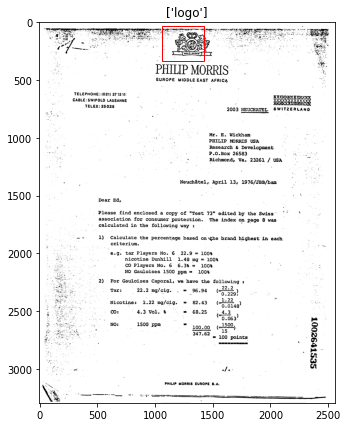

In [214]:
image = Image.open(image_path)

b_boxes = []
types = []
for obj in data:
    b_boxes.append(obj['position'])
    types.append(obj['type'])
    
draw_result(image, b_boxes,types)